In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

In [43]:
# Datei einlesen
file_path = 'C:/Users/Mazlum/Python_Project/PythonProject/data/fruit_data.xlsx' 
df = pd.read_excel(file_path)


print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   Unnamed: 0 fruit_type         color    size     weight
0           0      grape        Yellow    Tiny   8.303385
1           1      apple          Pink  Largee  80.976370
2           2     banana   Pale Yellow   Large  74.615192
3           3      grape           Red    Tiny   6.924070
4           4     banana  Creamy White  Largee  82.002542
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   fruit_type  200 non-null    object 
 2   color       200 non-null    object 
 3   size        200 non-null    object 
 4   weight      200 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 7.9+ KB
None
       Unnamed: 0      weight
count  200.000000  200.000000
mean    99.500000   59.047220
std     57.879185   46.697739
min      0.000000    1.000000
25%     49.750000    8.142752
50%     99.500

1. Data Cleansing

In [44]:
# Entfernen der unnötigen Spalte "Unnamed: 0"
fruit_data_cleaned = df.drop(columns=["Unnamed: 0"])

# Häufigkeit von Kategorien in 'fruit_type', 'color', und 'size'
fruit_type_counts = fruit_data_cleaned["fruit_type"].value_counts()
color_counts = fruit_data_cleaned["color"].value_counts()
size_counts = fruit_data_cleaned["size"].value_counts()

fruit_type_counts, color_counts, size_counts

(fruit_type
 apple     70
 grape     66
 banana    64
 Name: count, dtype: int64,
 color
 Green           58
 Yellow          43
 Red             31
 Creamy White    17
 Pink            17
 Purple          13
 Black           10
 Pale Yellow      9
 Yellow1          2
 Name: count, dtype: int64,
 size
 Small     57
 Medium    52
 Large     39
 Largee    29
 Tiny      23
 Name: count, dtype: int64)

In [45]:
# Korrektur von Schreibfehlern und Standardisierung
fruit_data_cleaned["color"] = fruit_data_cleaned["color"].replace({
    "Yellow1": "Yellow",
    "Pale Yellow": "Yellow",
    "Creamy White": "White"
})

fruit_data_cleaned["size"] = fruit_data_cleaned["size"].replace({
    "Largee": "Large"
})

# Überprüfung der Korrekturen
color_counts_corrected = fruit_data_cleaned["color"].value_counts()
size_counts_corrected = fruit_data_cleaned["size"].value_counts()

color_counts_corrected, size_counts_corrected

(color
 Green     58
 Yellow    54
 Red       31
 Pink      17
 White     17
 Purple    13
 Black     10
 Name: count, dtype: int64,
 size
 Large     68
 Small     57
 Medium    52
 Tiny      23
 Name: count, dtype: int64)

In [46]:
fruit_stats = fruit_data_cleaned.groupby(['fruit_type','color'])['weight'].agg(
	mean='mean',
	std='std',
	count='count',
	min='min',
	max='max',
	median='median',
	q25=lambda x: x.quantile(0.25),
	q75=lambda x: x.quantile(0.75)
)

In [47]:
fruit_stats

mean        std  count        min         max  \
fruit_type color                                                         
apple      Green   100.693760  44.309356     23   8.300753  250.000000   
           Pink     89.244963  23.537805     17  43.287969  130.721867   
           Red      77.841196  29.492983     17  25.038323  118.173616   
           Yellow  107.998496  50.923520     13  25.038323  250.000000   
banana     Green    74.881915  28.836185     20  26.524587  116.380543   
           White    73.445205  27.111757     17  32.326450  116.380543   
           Yellow   75.849715  28.298467     27  26.524587  116.380543   
grape      Black     6.072347   0.805516     10   4.651554    6.807727   
           Green     7.177158   2.149416     15   4.309718   10.902198   
           Purple    7.961395   2.162745     13   4.309718   10.902198   
           Red       6.911952   1.316672     14   4.651554    9.774546   
           Yellow    6.160495   2.171493     14   1.000000    9.456228   

                      median        q25         q75  
fruit_type color                                     
apple      Green   96.040216  76.667242  120.621006  
           Pink    86.739240  80.976370  106.271931  
           Red     92.035836  50.577337   96.380092  
           Yellow  96.380092  92.578934  123.068395  
banana     Green   74.344400  46.145790   95.451442  
           White   78.374787  57.498575   89.719116  
           Yellow  77.121200  56.056490  101.649728  
grape      Black    6.461906   5.842133    6.600542  
           Green    6.461906   5.822353    8.786653  
           Purple   8.303385   6.366469    9.774546  
           Red      7.210974   6.253502    7.603816  
           Yellow   6.096417   5.371310    7.112716

1.2 Fix Labels

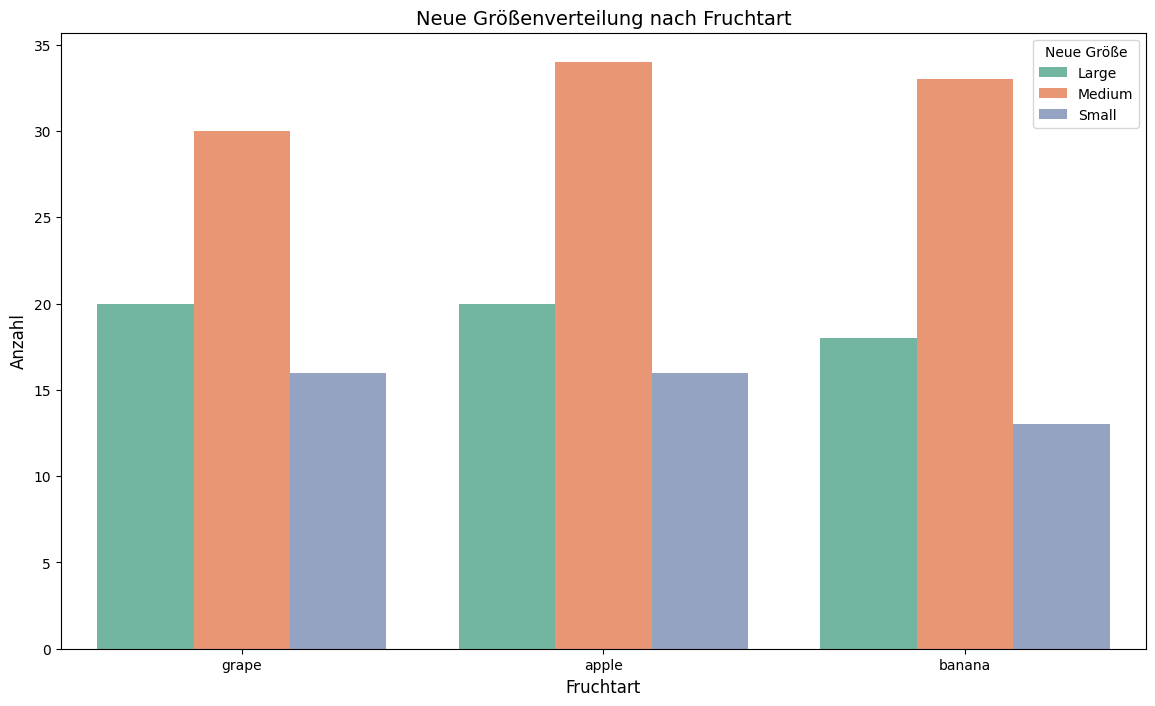

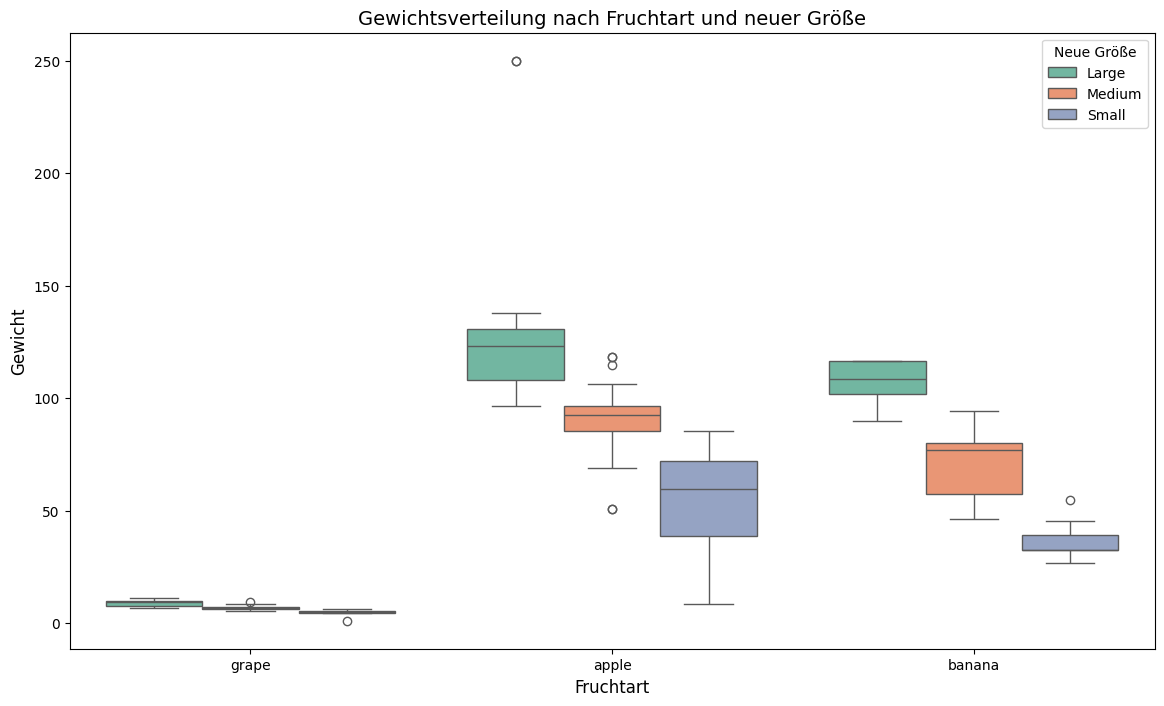

In [ ]:
# Berechnung der Statistiken für jede Kombination aus Fruchtart und Farbe
fruit_stats =fruit_stats.reset_index()

# Zuweisung von neuen Größen basierend auf q25 und q75
def assign_size_by_quantiles(row, stats):
    fruit_type = row['fruit_type']
    color = row['color']
    weight = row['weight']
    
    # Filtere die Stats für die entsprechende Fruchtart und Farbe
    stats_row = stats[(stats['fruit_type'] == fruit_type) & (stats['color'] == color)].iloc[0]
    
    if weight < stats_row['q25']:
        return 'Small'
    elif weight < stats_row['q75']:
        return 'Medium'
    else:
        return 'Large'

# Anwenden der neuen Größenklassifikation
fruit_data_cleaned['new_size'] = fruit_data_cleaned.apply(lambda row: assign_size_by_quantiles(row, fruit_stats), axis=1)

# Visualisierung der neuen Größen für jede Fruchtart
plt.figure(figsize=(14, 8))
sns.countplot(data=fruit_data_cleaned, x="fruit_type", hue="new_size", palette="Set2")
plt.title("Neue Größenverteilung nach Fruchtart", fontsize=14)
plt.xlabel("Fruchtart", fontsize=12)
plt.ylabel("Anzahl", fontsize=12)
plt.legend(title="Neue Größe", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
# Visualisierung des Gewichts für jede Fruchtart
plt.figure(figsize=(14, 8))
sns.boxplot(data=fruit_data_cleaned, x="fruit_type", y="weight", hue="new_size", palette="Set2")
plt.title("Gewichtsverteilung nach Fruchtart und neuer Größe", fontsize=14)
plt.xlabel("Fruchtart", fontsize=12)
plt.ylabel("Gewicht", fontsize=12)
plt.legend(title="Neue Größe", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


1.3 Preprocessing

In [ ]:
fruit_data_cleaned = fruit_data_cleaned.drop(columns=["size"])

x = fruit_data_cleaned.drop(columns=['fruit_type'])
y = fruit_data_cleaned['fruit_type'].map({'apple': 0, 'grape': 1, 'banana': 2})
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

# One-hot encoding for categorical features
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align the train and test set to have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)


In [ ]:
# Random Forest Modell ohne hyperp. tuning trainieren und evaluieren
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# Vorhersagen auf Testdaten
y_pred_rf = rf_model.predict(X_test_encoded)

# Evaluierung der Modellleistung
rf_report = classification_report(y_test, y_pred_rf, target_names=['apple', 'grape', 'banana'])
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Ausgabe der Ergebnisse im Print-Format
print("Random Forest: Modellleistung")
print(f"Genauigkeit: {rf_accuracy:.2f}")
print(f"Klassifikationsbericht:\n{rf_report}")

Random Forest: Modellleistung
Genauigkeit: 0.93
Klassifikationsbericht:
              precision    recall  f1-score   support

       apple       1.00      0.81      0.89        21
       grape       0.95      1.00      0.98        20
      banana       0.86      1.00      0.93        19

    accuracy                           0.93        60
   macro avg       0.94      0.94      0.93        60
weighted avg       0.94      0.93      0.93        60




#
Randomforrest mit Hyperparameter


In [37]:

# Mit Hyperparameter-Tuning-Ergebnisse
best_params_rf = {'n_estimators': 300, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 2}

# Random Forest Modell initialisieren und trainieren mit besten Parametern
rf_model_tuned = RandomForestClassifier(**best_params_rf, random_state=42)
rf_model_tuned.fit(X_train_encoded, y_train)

# Vorhersagen auf Testdaten
y_pred_rf_tuned = rf_model_tuned.predict(X_test_encoded)

# Evaluierung der Modellleistung
rf_report_tuned = classification_report(y_test, y_pred_rf_tuned, target_names=['apple', 'grape', 'banana'])
rf_accuracy_tuned = accuracy_score(y_test, y_pred_rf_tuned)

# Ausgabe der Ergebnisse im Print-Format
print("Random Forest (Tuned): Modellleistung")
print(f"Genauigkeit: {rf_accuracy_tuned:.2f}")
print(f"Klassifikationsbericht:\n{rf_report_tuned}")


Random Forest (Tuned): Modellleistung
Genauigkeit: 0.87
Klassifikationsbericht:
              precision    recall  f1-score   support

       apple       0.93      0.67      0.78        21
       grape       0.95      1.00      0.98        20
      banana       0.75      0.95      0.84        19

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.86        60
weighted avg       0.88      0.87      0.86        60



In [39]:
from sklearn.linear_model import LogisticRegression


# Daten skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Hyperparameter-Tuning-Ergebnisse
best_params = {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

# Logistische Regression initialisieren und trainieren mit besten Parametern
logistic_model_tuned = LogisticRegression(**best_params, max_iter=500, random_state=42)
logistic_model_tuned.fit(X_train_scaled, y_train)

# Vorhersagen auf Testdaten
y_pred_logistic_tuned = logistic_model_tuned.predict(X_test_scaled)

# Evaluierung der Modellleistung
logistic_report_tuned = classification_report(y_test, y_pred_logistic_tuned, target_names=['apple', 'grape', 'banana'])
logistic_accuracy_tuned = accuracy_score(y_test, y_pred_logistic_tuned)

# Ausgabe der Ergebnisse im Print-Format
print("Logistische Regression (Tuned): Modellleistung")
print(f"Genauigkeit: {logistic_accuracy_tuned:.2f}")
print(f"Klassifikationsbericht:\n{logistic_report_tuned}")


Logistische Regression (Tuned): Modellleistung
Genauigkeit: 0.93
Klassifikationsbericht:
              precision    recall  f1-score   support

       apple       0.90      0.90      0.90        21
       grape       0.95      1.00      0.98        20
      banana       0.94      0.89      0.92        19

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60



Entscheidungsbaum: Modellleistung


### Genauigkeit: 0.92

### Klassifikationsbericht:
```
              precision    recall  f1-score   support

       apple       1.00      0.76      0.86        21
       grape       0.95      1.00      0.98        20
      banana       0.83      1.00      0.90        19

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.91        60

```

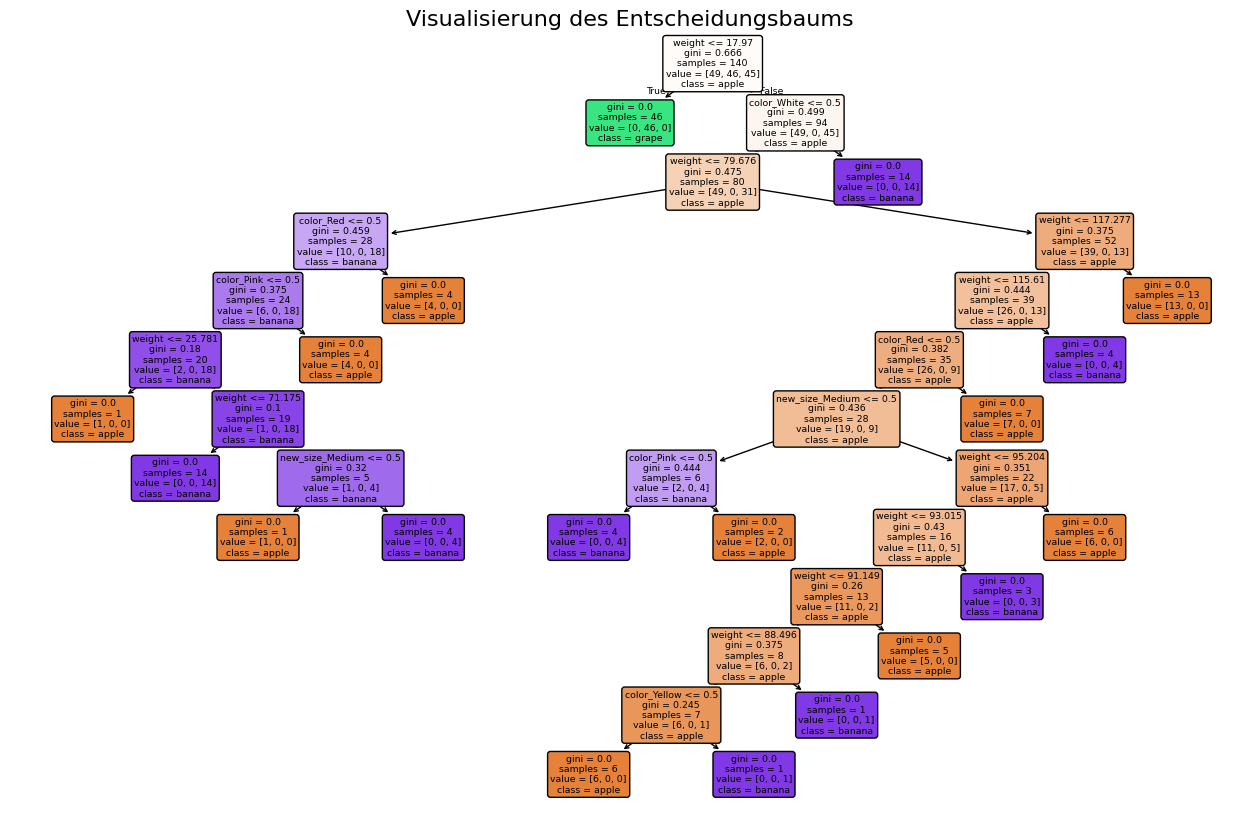

In [57]:
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, Markdown

# Entscheidungsbaum initialisieren und trainieren
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_encoded, y_train)

# Vorhersagen auf Testdaten
y_pred_tree = decision_tree_model.predict(X_test_encoded)

# Evaluierung der Modellleistung
tree_report = classification_report(y_test, y_pred_tree, target_names=['apple', 'grape', 'banana'])
tree_accuracy = accuracy_score(y_test, y_pred_tree)

# Ausgabe der Ergebnisse
print("Entscheidungsbaum: Modellleistung")
display(Markdown(f"### Genauigkeit: {tree_accuracy:.2f}"))
display(Markdown(f"### Klassifikationsbericht:\n```\n{tree_report}\n```"))

# Visualisierung des Entscheidungsbaums
plt.figure(figsize=(16, 10))
plot_tree(decision_tree_model, feature_names=X_train_encoded.columns, class_names=['apple', 'grape', 'banana'], filled=True, rounded=True)
plt.title("Visualisierung des Entscheidungsbaums", fontsize=16)
plt.show()


In [ ]:
# Assuming these variables are already defined in your notebook
# logistic_accuracy_tuned, rf_accuracy, rf_accuracy_tuned, tree_accuracy

print("Logistic Regression (Tuned) Accuracy:", logistic_accuracy_tuned)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest (Tuned) Accuracy:", rf_accuracy_tuned)
print("Decision Tree Accuracy:", tree_accuracy)

Logistic Regression (Tuned) Accuracy: 0.9333333333333333
Random Forest Accuracy: 0.9333333333333333
Random Forest (Tuned) Accuracy: 0.8666666666666667
Decision Tree Accuracy: 0.9166666666666666


In [ ]:
# Dictionary of models and their reports
reports = {
    "Logistic Regression (Tuned)": logistic_report_tuned,
    "Decision Tree": tree_report,
    "Random Forest (Tuned)": rf_report_tuned,
    "Random Forest": rf_report
}

# Function to parse classification report string into a dictionary
def parse_classification_report(report_str):
    report_data = []
    lines = report_str.split('\n')
    for line in lines[2:-3]:
        row_data = line.split()
        if len(row_data) >= 3:  # Ensure there are enough elements
            if row_data[0].strip() == 'accuracy':
                row = {'Class': row_data[0], 'Precision': None, 'Recall': None,
                       'F1-Score': float(row_data[1]), 'Support': int(row_data[2])}
            else:  
                row = {
                    'Class': row_data[0],
                    'Precision': float(row_data[1]),
                    'Recall': float(row_data[2]),
                    'F1-Score': float(row_data[3]),
                    'Support': int(row_data[4])
                }
            report_data.append(row)
    return report_data

# Initialize an empty list to hold all rows

rows = []
# Extract relevant metrics
for model_name, report in reports.items():
    parsed_report = parse_classification_report(report)
    for metrics in parsed_report:
        rows.append({
            'Model': model_name,
            'Class': metrics['Class'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1-Score': metrics['F1-Score'],
            'Support': metrics['Support']
        })

# Create a single DataFrame
comparison_df = pd.DataFrame(rows)

# Display the DataFrame
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Model Comparison Report", dataframe=comparison_df)


Model Comparison Report
